<a href="https://colab.research.google.com/github/titomartini/projeto_grupo3/blob/master/EmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# o pacote do librosa tá desatualizado no colab
pip install git+https://github.com/librosa/librosa

In [0]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import math
import os
import time as time_lib
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from IPython.display import Audio
from IPython import display
import librosa
import scipy
import pickle

# READING DB, SEGMENTING, EXTRACTING FEATURES and ORGANIZING

In [0]:
# READING DB

df = pd.DataFrame(columns = ['actor','statement','repetion','emotion','intensity','signal'])
sample_rate = 16000

for i in np.arange(1,25,1):
    path = '/content/drive/My Drive/RAVDESS/Actor_' + format(i, '02')
    for file in os.listdir(path):
        text = os.path.splitext(file)[0].split('-')
        signal = (librosa.load(path + '/' + file, sr = sample_rate))[0]
        df.loc[len(df)] = [i, text[4], text[5], text[2], text[3], signal]
    print('done with Actor ', i)

done with Actor  1
done with Actor  2
done with Actor  3
done with Actor  4
done with Actor  5
done with Actor  6
done with Actor  7
done with Actor  8
done with Actor  9
done with Actor  10
done with Actor  11
done with Actor  12
done with Actor  13
done with Actor  14
done with Actor  15
done with Actor  16
done with Actor  17
done with Actor  18
done with Actor  19
done with Actor  20
done with Actor  21
done with Actor  22
done with Actor  23
done with Actor  24


In [0]:
# SEGMENTING

df['signal_limited'] = ''
input_time = 3.7

for i, row in df.iterrows():
    diff = len(row['signal']) - sample_rate*input_time
    left = math.ceil(abs(diff/2))
    right = math.floor(abs(diff/2))
    if (diff <= 0):
        df.loc[i,'signal_limited'] = np.pad(row['signal'], (left, right), 'constant')
    elif (diff > 0):
        df.loc[i,'signal_limited'] = row['signal'][left:-right]
  
df['signal_limited'].apply(lambda x: len(x)/sample_rate).describe()

count    1.449000e+03
mean     3.700000e+00
std      1.003988e-13
min      3.700000e+00
25%      3.700000e+00
50%      3.700000e+00
75%      3.700000e+00
max      3.700000e+00
Name: signal_limited, dtype: float64

In [0]:
# FEATURE EXTRACTION

args = {
    'sr' : sample_rate,
    'hop_length' : int(0.010*sample_rate),    # frame shift
    'win_length' : int(0.025*sample_rate),    # frame size
    'window' : scipy.signal.hamming,
    'n_fft' : 512
}

# MFCC EXTRACTION and transpose to the format (frames, features)
df['mfcc'] = df['signal_limited'].map(lambda x: librosa.feature.mfcc(y = x, n_mfcc = 13, **args).T)

# MELSPECTRO EXTRACTION and transpose to the format (frames, features)
df['melspectro'] = df['signal_limited'].map(lambda x: librosa.feature.melspectrogram(y = x, n_mels = 40, **args).T)

In [0]:
# ORGANIZING

# GENDER
def gender(actor):
    if (int(actor) % 2) == 1:
        return 'M'
    else:
        return 'F'
df['gender'] = df['actor'].map(gender)

# EMOTION LABEL
emo_dictionary = {
    '01' : 'neutral',
    '02' : 'calm',
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}
df['emo_label'] = df['emotion'].replace(emo_dictionary)

# REMOVE 3 CONFUSING EMOTIONS
df = df[~df['emo_label'].isin(['fearful', 'disgust', 'surprised'])].reset_index()

# NEW TARGET
df['gender_emotion'] = df['gender'] + '_' + df['emo_label']

In [0]:
def delta(feat, N):
    delta_feat = np.empty_like(feat)
    padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(len(feat)):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1])   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat/(2 * sum([i**2 for i in range(1, N+1)]))

In [0]:
df['mfcc_d'] = df['mfcc'].map(lambda x: delta(x, 2))
df['mfcc_d_d'] = df['mfcc_d'].map(lambda x: delta(x, 2))

In [0]:
def featuresMerge(x, features = ['mfcc', 'mfcc_d']):
    result = [[] for i in range(len(x.at[features[0]]))]
    for feature in features:
        result = np.append(result, x[feature], 1)
    return result

In [0]:
df['features'] = df.apply(lambda x: featuresMerge(x), axis = 1)

In [0]:
# WRITE PICKLE
with open('/content/drive/My Drive/ravdess_data.pkl', 'wb') as f:
    df.to_pickle(f, compression=None)

In [0]:
# READ PICKLE
with open('/content/drive/My Drive/ravdess_data.pkl', 'rb') as f:
    df = pd.read_pickle(f, compression=None)

In [0]:
def preprocessingSignal(signal = []):
    sample_rate = 16000
    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], [x1 - x2 for (x1, x2) in zip(signal[1:], [i * pre_emphasis for i in signal[:-1]])])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # Filter Banks
    nfilt = 3
    low_freq_mel = (2595 * np.log10(1 + 75 / 700))
    high_freq_mel = (2595 * np.log10(1 + 255 / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Mean normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

    return filter_banks

In [0]:
df['2_filterbanks'] = df['signal_limited'].map(lambda x: np.delete(preprocessingSignal(x), 1, 1))

In [0]:
df['2_filterbanks_flat'] = df['2_filterbanks'].map(lambda x: x.flatten())

In [0]:
df['mfcc_flat'] = df['mfcc'].map(lambda x: x.flatten())

# GMM

In [0]:
train, test = train_test_split(df[['mfcc_flat', 'emo_label', 'gender_emotion']], test_size = 0.2, random_state = 40)

In [0]:
train['gender_emotion'].value_counts(), test['gender_emotion'].value_counts()

(F_calm       80
 M_happy      79
 M_sad        78
 M_angry      78
 F_angry      78
 F_happy      78
 M_calm       72
 F_sad        70
 F_neutral    44
 M_neutral    40
 Name: gender_emotion, dtype: int64, F_sad        26
 M_calm       24
 F_calm       20
 F_happy      18
 M_angry      18
 F_angry      18
 M_sad        18
 M_happy      17
 M_neutral     8
 F_neutral     8
 Name: gender_emotion, dtype: int64)

In [0]:
for target in ['emo_label', 'gender_emotion']:
    # TRAIN
    emo_list = sorted(df[target].unique())
    gmm = [[] for x in range(len(emo_list))]
    for i, emotion in enumerate(emo_list):
        gmm[i] = GaussianMixture(n_components = 4, max_iter = 1000, covariance_type = 'tied', n_init = 1)
        gmm[i].fit(train[train[target] == emotion]['mfcc_flat'].tolist())
        print('Done with: ', emotion)
    # TEST
    for i, emotion in enumerate(emo_list):
        test[emotion] = gmm[i].score_samples(test['mfcc_flat'].values.tolist())
    test['prediction'] = test[emo_list].idxmax(axis = 1)
    test['score'] = np.where(test[target] == test['prediction'], 1, 0)
    # ACCURACY
    print('Accuracy: ' + '{:.1%}'.format(test['score'].sum()/len(test)))
    # CONFUSION MATRIX
    plt.figure(figsize = (10,7))
    sns.set(font_scale = 1.2)
    ax = sns.heatmap( pd.DataFrame(confusion_matrix(test[target], test['prediction'], labels = emo_list), emo_list, emo_list),
                      annot = True,
                      cmap = 'Blues'
                    )
    ax.set_ylim(len(cm), 0)
    # ax.set_title('Confusion Matrix', fontsize = 35)
    ax.set_xlabel('Predicted', fontsize = 25)
    ax.set_ylabel('Truth', fontsize = 25)
    plt.show()

Done with:  angry
Done with:  calm
Done with:  happy
Done with:  neutral
Done with:  sad
Accuracy: 68.6%


NameError: ignored

<Figure size 720x504 with 0 Axes>

# GMM - frame by frame

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

In [0]:
train, test = train_test_split(df[['features', 'emo_label', 'gender_emotion']], test_size = 0.2, random_state = 40)

# EXPLODE audio into frames
train = (train['features']
         .apply(lambda x: pd.Series(x.tolist()))
         .assign(emo_label = train['emo_label'])
         .assign(gender_emotion = train['gender_emotion'])
         .melt(id_vars = ['emo_label','gender_emotion'], value_name = 'features')
        )

test = test.reset_index()

COVARIANCE OPTIMIZATION

In [0]:
param_grid = {
    'n_components' : [4, 8, 16, 32, 48, 64, 80, 96],
    'max_iter' : [1000],
    # 'tol' : [1e-3],
    'covariance_type' : ['diag','tied','full','spherical'],
    'n_init' : [1],
    'init_params' : ['kmeans']
}

result = []
for param in ParameterGrid(param_grid):
    # TRAIN
    emo_list = sorted(df['emo_label'].unique())
    gmm = [[] for x in range(len(emo_list))]
    for i, emotion in enumerate(emo_list):
        gmm[i] = GaussianMixture(**param)
        gmm[i].fit(train[train['emo_label'] == emotion]['mfcc'].tolist())
    print('Done with: ', param)

    # TEST
    for i, emotion in enumerate(emo_list):
        test[emotion] = test['mfcc'].apply(gmm[i].score)

    test['prediction'] = test[emo_list].idxmax(axis = 1)
    test['score'] = np.where(test['emo_label'] == test['prediction'], 1, 0)

    # ACCURACY
    acc = test['score'].sum()/len(test)
    print('Accuracy: ' + '{:.1%}'.format(acc))
    result.append([param['n_components'], param['covariance_type'], acc])

df_results = pd.DataFrame(result, columns = ['Components', 'Covariance', 'Accuracy']) 

KeyError: ignored

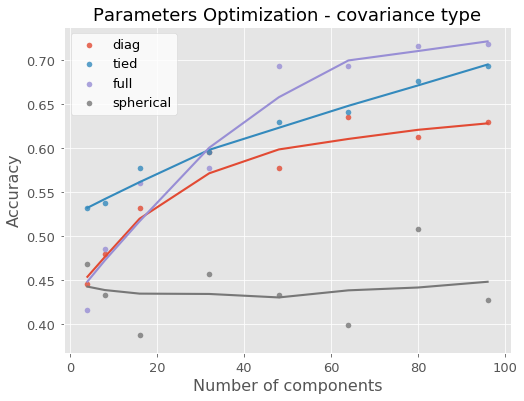

In [0]:
plt.figure(figsize = (8, 6))
for cov in df_results['Covariance'].unique():
    aux = df_results[df_results['Covariance'] == cov]
    sns.regplot(x = aux['Components'], y = aux['Accuracy'], label = cov, lowess = True)
plt.style.use('ggplot')
plt.title('Parameters Optimization - covariance type', fontsize = 18)
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(loc = 'best', prop = {'size': 13}, facecolor = 'white')
plt.tick_params(labelsize= 13)

In [0]:
with open('/content/drive/My Drive/gmm_params_opt.pkl', 'wb') as f:
    pickle.dump(df_results, f)

In [0]:
with open('/content/drive/My Drive/gmm_params_opt.pkl', 'rb') as f:
    df_results = pickle.load(f)

TARGET OPTIMIZATION

In [0]:
param_grid = {
    'n_components' : [64, 80, 96, 112, 128, 144, 160, 176, 192],
    'max_iter' : [1000],
    # 'tol' : [1e-3],
    'covariance_type' : ['tied'],
    'n_init' : [1],
    'init_params' : ['kmeans']
}

result = []
for target in ['emo_label','gender_emotion']:
    for param in ParameterGrid(param_grid):
        # TRAIN
        emo_list = sorted(df[target].unique())
        gmm = [[] for x in range(len(emo_list))]
        for i, emotion in enumerate(emo_list):
            gmm[i] = GaussianMixture(**param)
            gmm[i].fit(train[train[target] == emotion]['mfcc'].tolist())
        print('Done with: ', param)

        # TEST
        for i, emotion in enumerate(emo_list):
            test[emotion] = test['mfcc'].apply(gmm[i].score)

        test['prediction'] = test[emo_list].idxmax(axis = 1)
        test['score'] = np.where(test[target] == test['prediction'], 1, 0)

        # ACCURACY
        acc = test['score'].sum()/len(test)
        print('Accuracy: ' + '{:.1%}'.format(acc))
        result.append([target, param['n_components'], param['covariance_type'], acc])

df_results = pd.DataFrame(result, columns = ['Target', 'Components', 'Covariance', 'Accuracy']) 

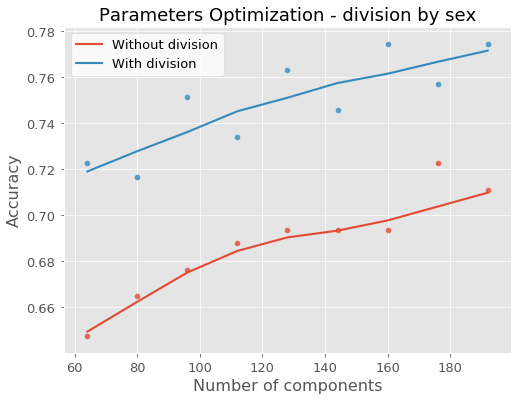

In [0]:
plt.figure(figsize = (8, 6))
for target in df_results['Target'].unique():
    aux = df_results[df_results['Target'] == target]
    sns.regplot(x = aux['Components'], y = aux['Accuracy'], label = target, lowess = True)
plt.style.use('ggplot')
plt.title('Parameters Optimization - division by sex', fontsize = 18)
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(['Without division', 'With division'], loc = 'best', prop = {'size': 13}, facecolor = 'white')
plt.tick_params(labelsize= 13)


In [0]:
with open('/content/drive/My Drive/gmm_gender.pkl', 'wb') as f:
    pickle.dump(df_results, f)

In [0]:
with open('/content/drive/My Drive/gmm_gender.pkl', 'rb') as f:
    df_results = pickle.load(f)

FINAL RESULTS

Done with:  F_angry
Done with:  F_calm
Done with:  F_happy
Done with:  F_neutral
Done with:  F_sad
Done with:  M_angry
Done with:  M_calm
Done with:  M_happy
Done with:  M_neutral
Done with:  M_sad
gender_emotion Accuracy: 80.9%


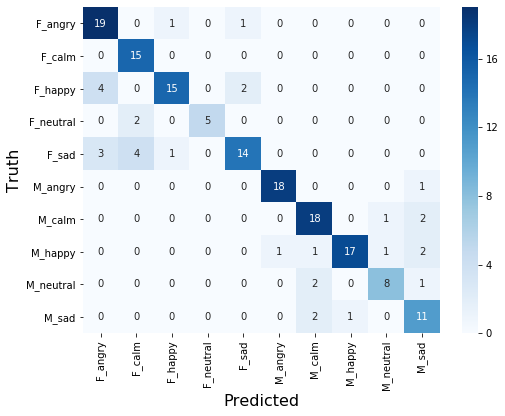

Done with:  angry
Done with:  calm
Done with:  happy
Done with:  neutral
Done with:  sad
emo_label Accuracy: 78.6%


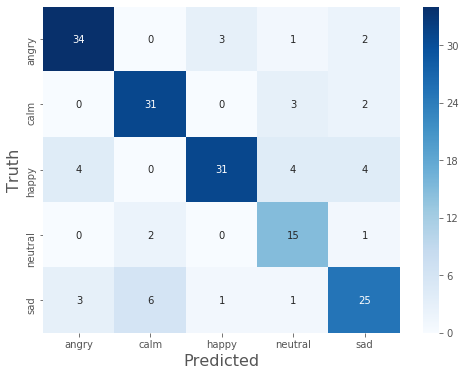

In [0]:
results = []
for target in ['gender_emotion', 'emo_label']:
    # TRAIN
    emo_list = sorted(df[target].unique())
    gmm = [[] for x in range(len(emo_list))]
    for i, emotion in enumerate(emo_list):
        gmm[i] = GaussianMixture(n_components = 512, max_iter = 1000, covariance_type = 'tied', n_init = 1)
        gmm[i].fit(train[train[target] == emotion]['features'].tolist())
        print('Done with: ', emotion)

    # TEST
    for i, emotion in enumerate(emo_list):
        test[emotion] = test['features'].apply(gmm[i].score)
    test['prediction'] = test[emo_list].idxmax(axis = 1)
    test['score'] = np.where(test[target] == test['prediction'], 1, 0)

    # ACCURACY
    acc = test['score'].sum()/len(test)
    print(target + ' Accuracy: ' + '{:.1%}'.format(acc))

    # CONFUSION MATRIX
    cm = confusion_matrix(test[target], test['prediction'], labels = emo_list)
    results.append([target, acc, cm])
    plt.figure(figsize = (8,6))
    ax = sns.heatmap( pd.DataFrame(cm, emo_list, emo_list),
                      annot = True,
                      cmap = 'Blues'
                    )
    plt.style.use('ggplot')
    ax.set_ylim(len(cm), 0)
    # plt.title('Confusion Matrix', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 16)
    plt.ylabel('Truth', fontsize = 16)
    plt.tick_params(labelsize= 10)
    plt.show()

# CNN

In [0]:
import keras

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D



WITH DIVISION OF SEX

In [0]:
lb = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(df['mfcc'],
                                                    np_utils.to_categorical(lb.fit_transform(df['gender_emotion'])),
                                                    test_size = 0.2, random_state = 40
                                                    )

emo_index = list(lb.classes_)
n_frames, n_features = X_train.iloc[0].shape
n_targets = y_train.shape[1]

X_train = np.asarray([x.T for x in X_train]).reshape(len(X_train), n_frames, n_features, 1)
X_test = np.asarray([x.T for x in X_test]).reshape(len(X_test), n_frames, n_features, 1)

In [0]:
## CONSTATAÇÕES NA EXPLORAÇÃO DO CNN:
## Dropout ajuda a manter as curvas de treino e validação mais perto
## Ter mais do que 7 camadas não traz beneficios ou até piora
## Maxpooling só na dimensão temporal melhora

args = {
    'kernel_size' : (5,5),
    'padding' : 'same',
    'activation' : 'relu'
}

model = Sequential()

model.add(Convolution2D(64, **args, input_shape = (n_frames, n_features, 1)))
model.add(Convolution2D(64, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))
model.add(Convolution2D(128, **args))
model.add(Convolution2D(128, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))
model.add(Convolution2D(512, **args))
model.add(Convolution2D(512, **args))
model.add(Convolution2D(512, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(n_targets, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
epochs = 100
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
cnnhistory = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, validation_data = (X_test, y_test))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 697 samples, validate on 175 samples
Epoch 1/100





697/697 [==============================] - 19s 27ms/step - loss: 3.3792 - acc: 0.1593 - val_loss: 2.6352 - val_acc: 0.1200
Epoch 2/100
697/697 [==============================] - 9s 13ms/step - loss: 2.2823 - acc: 0.1722 - val_loss: 2.0434 - val_acc: 0.2057
Epoch 3/100
697/697 [==============================] - 9s 13ms/step - loss: 2.0758 - acc: 0.2238 - val_loss: 2.1804 - val_acc: 0.1143
Epoch 4/100
697/697 [==============================] - 9s 13ms/step - loss: 1.8456 - acc: 0.3056 - val_loss: 1.9553 - val_acc: 0.2629
Epoch 5/100
697/697 [==============================] - 9s 13ms/step - loss: 1.6639 - acc: 0.3773 - val_loss: 1.8989 - val_acc: 0.3829
Epoch 6/100
697/697 [==============================] - 9s 13ms/step - loss: 1.4633 - acc: 0.4534 - val_loss: 2.5817 - val_acc: 0.2000
Epoch 7/100
697/697 [========================

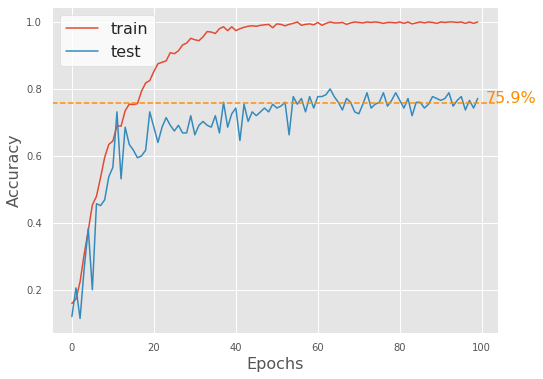

In [0]:
# TRAINING HISTORY
plt.figure(figsize = (8,6))
x = np.linspace(0, epochs, 1000)
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])

performance = np.mean(cnnhistory.history['val_acc'][-5:]) # average of last 5 epochs
plt.axhline(y = performance, linestyle = '--', color = '#FF8C00')
plt.text((epochs+1), performance, '{:.1%}'.format(performance), fontsize = 16, color = '#FF8C00')

plt.style.use('ggplot')
plt.ylabel('Accuracy', fontsize = 16)
plt.xlabel('Epochs', fontsize = 16)
plt.tick_params(labelsize= 10)
# plt.legend(['train', 'test'], loc = 'upper left')
plt.legend(['train', 'test'], loc = 'best', prop = {'size': 16}, facecolor = 'white')

plt.show()

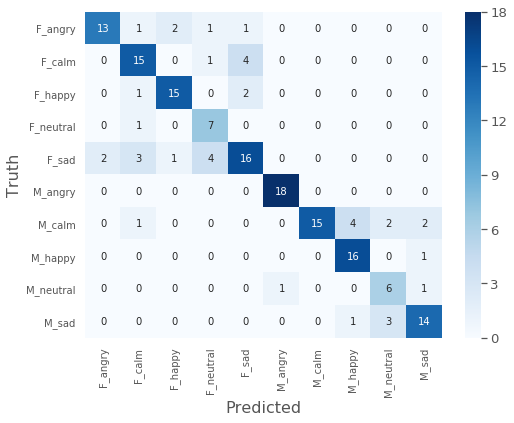

In [0]:
# CONFUSION MATRIX
predicted = (model.predict(X_test)).argmax(axis = 1)
truth = y_test.argmax(axis = 1)

plt.figure(figsize = (8,6))
cm = confusion_matrix(truth, predicted)
ax = sns.heatmap( pd.DataFrame(cm, emo_index, emo_index),
                  annot = True,
                  cmap = 'Blues'
                )
plt.style.use('ggplot')
ax.set_ylim(len(cm), 0)
# plt.title('Confusion Matrix', fontsize = 18)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('Truth', fontsize = 16)
plt.tick_params(labelsize= 10)
plt.show()

WITHOUT SEX DIVISION

In [0]:
lb = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(df['mfcc'],
                                                    np_utils.to_categorical(lb.fit_transform(df['emo_label'])),
                                                    test_size = 0.2, random_state = 40
                                                    )

emo_index = list(lb.classes_)
n_frames, n_features = X_train.iloc[0].shape
n_targets = y_train.shape[1]

X_train = np.asarray([x.T for x in X_train]).reshape(len(X_train), n_frames, n_features, 1)
X_test = np.asarray([x.T for x in X_test]).reshape(len(X_test), n_frames, n_features, 1)

In [0]:
args = {
    'kernel_size' : (5,5),
    'padding' : 'same',
    'activation' : 'relu'
}

model = Sequential()

model.add(Convolution2D(64, **args, input_shape = (n_frames, n_features, 1)))
model.add(Convolution2D(64, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))
model.add(Convolution2D(128, **args))
model.add(Convolution2D(128, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))
model.add(Convolution2D(512, **args))
model.add(Convolution2D(512, **args))
model.add(Convolution2D(512, **args))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(n_targets, activation='softmax'))

In [0]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
epochs = 100
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
cnnhistory = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, validation_data = (X_test, y_test))

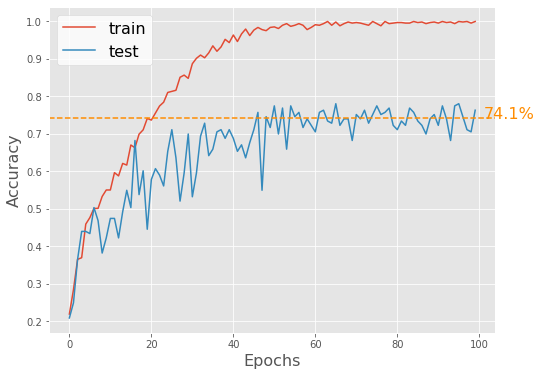

In [0]:
# TRAINING HISTORY
plt.figure(figsize = (8,6))
x = np.linspace(0, epochs, 1000)
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])

performance = np.mean(cnnhistory.history['val_acc'][-5:]) # average of last 5 epochs
plt.axhline(y = performance, linestyle = '--', color = '#FF8C00')
plt.text((epochs+1), performance, '{:.1%}'.format(performance), fontsize = 16, color = '#FF8C00')

plt.style.use('ggplot')
plt.ylabel('Accuracy', fontsize = 16)
plt.xlabel('Epochs', fontsize = 16)
plt.tick_params(labelsize= 10)
# plt.legend(['train', 'test'], loc = 'upper left')
plt.legend(['train', 'test'], loc = 'best', prop = {'size': 16}, facecolor = 'white')

plt.show()

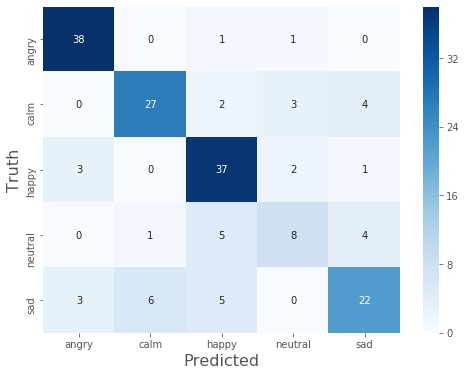

In [0]:
# CONFUSION MATRIX
predicted = (model.predict(X_test)).argmax(axis = 1)
truth = y_test.argmax(axis = 1)

plt.figure(figsize = (8,6))
cm = confusion_matrix(truth, predicted)
ax = sns.heatmap( pd.DataFrame(cm, emo_index, emo_index),
                  annot = True,
                  cmap = 'Blues'
                )
plt.style.use('ggplot')
ax.set_ylim(len(cm), 0)
# plt.title('Confusion Matrix', fontsize = 18)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('Truth', fontsize = 16)
plt.tick_params(labelsize= 10)
plt.show()

# SVM

In [0]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [0]:
def extract_spec_mfcc(audio):
  all_mfccs=[]
  for frame in audio:
      for spec_mfcc in frame:
        all_mfccs.append(spec_mfcc)
  return np.hstack(all_mfccs)

df['specific_mfcc']=df['mfcc'].apply(extract_spec_mfcc)

In [0]:
train, test = train_test_split(df[['specific_mfcc', 'emo_label']], test_size = 0.2, random_state = 40)

In [0]:
#model = svm.SVC(kernel='linear')
model = svm.SVC(kernel='linear')

In [0]:
#model.fit(train['mfccs_mean'].values.tolist(), train['gender_emotion'].values.tolist())
model.fit(train['specific_mfcc'].values.tolist(), train['emo_label'].values.tolist())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
#for prediction in model.predict(test['mfccs_mean'].values.tolist()):
#  test['prediction']=prediction

for prediction in model.predict(test['specific_mfcc'].values.tolist()):
  test['prediction']=prediction

In [0]:
#test['prediction']=model.predict(test['mfccs_mean'].values.tolist())
test['prediction']=model.predict(test['specific_mfcc'].values.tolist())

In [0]:
test['score'] = np.where(test['emo_label'] == test['prediction'], 1, 0)

In [0]:
# ACCURACY
print('Accuracy: ' + '{:.1%}'.format(test['score'].sum()/len(test)))

Accuracy: 66.3%


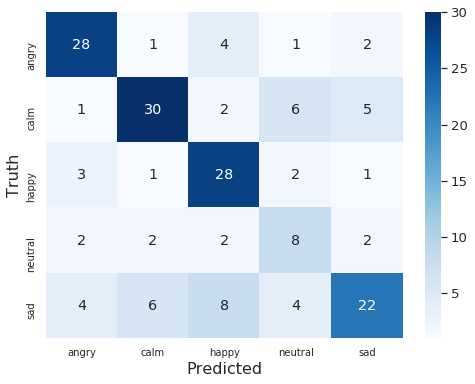

In [0]:
# CONFUSION MATRIX
emo_list = sorted(df['emo_label'].unique())
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
cm = confusion_matrix(test['emo_label'], test['prediction'])
ax = sns.heatmap( pd.DataFrame(confusion_matrix(test['emo_label'], test['prediction'], labels = emo_list), emo_list, emo_list),
                  annot = True,
                  cmap = 'Blues'
                )
plt.style.use('ggplot')
ax.set_ylim(len(cm), 0)
# plt.title('Confusion Matrix', fontsize = 18)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('Truth', fontsize = 16)
plt.tick_params(labelsize= 10)
plt.show()